# Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a well-known matrix factorization technique in recommender systems theory, its practical application can be challenging, especially with very large and sparse datasets typical in real-world scenarios. This has led to the popularity of alternative methods like Alternating Least Squares (ALS).


SVD decomposes a matrix into three separate matrices: U (user features), Σ (singular values), and V^T (item features). In the context of a recommender system like Goodreads:

- The original matrix represents user ratings for books.
- SVD decomposes this matrix into user and book feature matrices.
- The singular values in Σ represent the strength of each latent feature.
- By multiplying these matrices, we can approximate the original ratings matrix.
- This approximation helps predict missing ratings, enabling recommendations.

In [1]:
import sys
import os

# Extending the system path to include the parent directory for module imports
sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Surprise library imports for implementing SVD and model evaluation
from surprise import Dataset, Reader, SVD
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Local utility functions for preprocessing and metrics
from src.utils import preprocess, metrics

# Setting up matplotlib for inline display in Jupyter notebooks
%matplotlib inline

# Suppressing warnings for a cleaner notebook presentation. Note: Pay attention to these in a development environment.
import warnings
warnings.simplefilter("ignore")

## Prepare data

In [2]:
# Loading ratings data
rating_file = os.path.join('..', 'src', 'data', 'goodreads_2m', 'ratings.csv')
ratings = pd.read_csv(rating_file)

# Displaying the shape of the dataset and a random sample of 5 entries
print(f'Shape: {ratings.shape}')
ratings.sample(5, random_state=123)

Shape: (91226, 3)


,user_id,book_name,rating
74505,2540,"A Game of Thrones (A Song of Ice and Fire, #1)",4
60643,5886,The Amazing Adventures of Kavalier & Clay,4
87603,4411,The World to Come,5
81524,4934,Harry Potter and the Philosopher's Stone (Harr...,5
60556,5791,"Bloodsucking Fiends (A Love Story, #1)",3


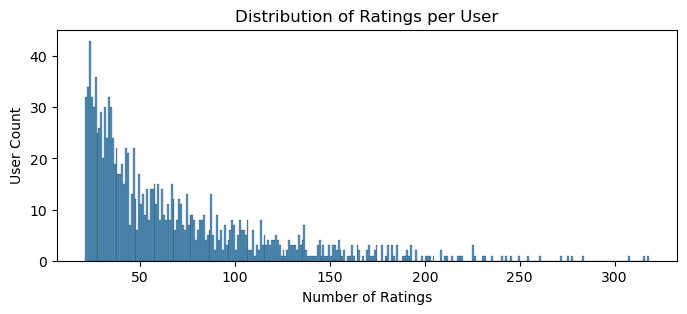

In [3]:
# Visualizing the distribution of the number of ratings per user
users_count = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False).reset_index()

# Setting the size of the plot for better visibility
plt.figure(figsize=(8, 3))

# Creating a histogram to show the distribution
fig = sns.histplot(users_count['rating'], binwidth=1, kde=False)
fig.set_title('Distribution of Ratings per User')
fig.set_xlabel('Number of Ratings')
fig.set_ylabel('User Count')

# Displaying the plot
plt.show()


## Data Split

In [4]:
# Displaying basic statistics of the dataset
print(f'Number of Reviews: {len(ratings)}')
print(f'Number of Users: {ratings.user_id.nunique()}')
print(f'Number of Books: {ratings.book_name.nunique()}')

Number of Reviews: 91226
Number of Users: 1371
Number of Books: 2720


For the train test splitting, we want to keep the same users in both datasets and so we use stratified splitting below

In [5]:
# Stratified train-test split to maintain the same users in both sets
train_size = 0.75
train, test = preprocess.stratified_split(ratings, 'user_id', train_size)

# Displaying the shape of train and test sets and checking user overlap
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')
print(f'Do they have the same users?: {set(train.user_id) == set(test.user_id)}')

Train Shape: (68435, 3)
Test Shape: (22791, 3)
Do they have the same users?: True


## SVD

In [6]:
# Setting up the reader with rating scale based on the train set
reader = Reader(rating_scale=(train['rating'].min(), train['rating'].max()))
data = Dataset.load_from_df(train[['user_id', 'book_name', 'rating']], reader)  # Assuming 'book_name' should be 'book_id'

# SVD model instantiation with specified hyperparameters
svd = SVD(random_state=0, n_epochs=20, lr_all=0.005, n_factors=50, reg_all=0.05, verbose=False)

# Performing 5-fold cross-validation to evaluate the model
cross_validation_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Calculating and printing the mean RMSE and MAE
mean_rmse = cross_validation_results['test_rmse'].mean()
mean_mae = cross_validation_results['test_mae'].mean()
print(f"Mean RMSE: {mean_rmse}")
print(f"Mean MAE: {mean_mae}")

# Fitting the SVD model on the entire train set
surprise_train = data.build_full_trainset()
svd.fit(surprise_train)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8782  0.8759  0.8779  0.8804  0.8670  0.8759  0.0047  
MAE (testset)     0.6990  0.6963  0.6946  0.6991  0.6902  0.6958  0.0033  
Fit time          0.20    0.20    0.19    0.22    0.21    0.20    0.01    
Test time         0.05    0.03    0.03    0.03    0.03    0.04    0.01    
Mean RMSE: 0.8758843761173013
Mean MAE: 0.6958392264513296


## Recommend

In [7]:
# Generating predictions for user-item pairs not in the training set and filtering out already rated items
testset = surprise_train.build_anti_testset()
predictions = svd.test(testset)

# Converting predictions to DataFrame and filtering out seen items
predictions_df = pd.DataFrame(predictions, columns=['user_id', 'book_name', 'actual', 'predicted', 'details'])
seen_books = train[['user_id', 'book_name']].copy()
seen_books['seen'] = True
merged = pd.merge(seen_books, predictions_df, on=['user_id', 'book_name'], how="outer")
unseen_predictions = merged[merged['seen'].isnull()].drop(['seen', 'actual', 'details'], axis=1)
all_preds = [unseen_predictions]

In [8]:
# Extracting top k recommendations for each user
top_k_recommendations = []
top_k = 10  # Number of recommendations per user
for predictions in all_preds:
    predictions['rank'] = predictions.groupby('user_id')['predicted'].rank(method="first", ascending=False)
    top_recommendations = predictions[predictions['rank'] <= top_k]
    top_k_recommendations.append(top_recommendations)

## Evaluation Metrics

The performance of our model is evaluated using the test set, which consists of the exact same users in the training set but with books the users have reviewed that the model has not seen before. A good model will recommend books that the user has also reviewed in the test set.

---

### Precision@k

Out of the books that are recommended, what proportion is relevant. Relevant in this case is if the user has reviewed the book.

A precision@10 of about 0.1 means that about 10% of the recommendations are relevant to the user. In other words, out of the 10 recommendations made, on average a user will have 1 book that is actually relevant.

### Recall@k

Out of all the relevant books (in the test set), how many are recommended.

A recall@10 of 0.1 means that about 10% of the relevant books were recommended. By definition you can see how even if all the recommendations made were relevant, recall@k is capped by k. A higher k means that more relevant books can be recommended.

### Mean Average Precision (MAP)

Calculate the average precision for each user and average all the average precisions over all users. Penalizes incorrect rankings of books.

### Normalized Discounted Cumulative Gain (NDGC)

Looks at both relevant books and the ranking order of the relevant books. Normalized by the total number of users.

---


In [9]:
# Evaluating model performance with precision, recall, MAP, and NDCG metrics
model_metrics = {'svd': {}}
for recommendation in top_k_recommendations:
    # Calculate metrics
    precision_at_k = metrics.precision_at_k(recommendation, test, 'user_id', 'book_name', 'rank')
    recall_at_k = metrics.recall_at_k(recommendation, test, 'user_id', 'book_name', 'rank')
    map_score = metrics.mean_average_precision(recommendation, test, 'user_id', 'book_name', 'rank')
    ndcg_score = metrics.ndcg(recommendation, test, 'user_id', 'book_name', 'rank')
    
    # Assigning calculated metrics to the model_metrics dictionary
    model_metrics['svd'] = {
        'precision': precision_at_k,
        'recall': recall_at_k,
        'MAP': map_score,
        'NDCG': ndcg_score
    }
    
for model, values in model_metrics.items():
    print(f'------ {model} -------',
          f'Precision: {values["precision"]:.6f}',
          f'Recall: {values["recall"]:.6f}',
          f'MAP: {values["MAP"]:.6f} ',
          f'NDCG: {values["NDCG"]:.6f}',
          '', sep='\n')

------ svd -------
Precision: 0.007586
Recall: 0.004831
MAP: 0.001789 
NDCG: 0.008222

